# NER using LSTM

after several failed attempts, I will be using LSTM, I'm following the following tutorial for this:
https://www.depends-on-the-definition.com/lstm-with-char-embeddings-for-ner/



In [1]:
# importing stuffs

import json
import numpy as np
import pandas as pd
# importing regex
import re

In [2]:
with open("/content/drive/MyDrive/Colab Notebooks/NLP/main.jsonl", 'r') as jsonl_file:
  jsonl_list = list(jsonl_file)

In [3]:
# creating two list to store the sentence and annotation
# which will later be included into a dataframe

s_list = [] # sentence list
t_list = [] # annotation list

for jsonl_string in jsonl_list:
  json_values = json.loads(jsonl_string)
  s_list.append(json_values[0])
  t_list.append(json_values[1])
  # print(jsonl_string)

### primary dataframe for data preprocessing

In [4]:
dfp = pd.DataFrame()

In [5]:
dfp['sentence'] = s_list

# converting the tag list into string
t_string_list = [' '.join(tags) for tags in t_list]

# dfp['tag'] = t_list
dfp['tag string'] = t_string_list
dfp.head()

,sentence,tag string
0,অগ্রণী ব্যাংকের জ্যেষ্ঠ কর্মকর্তা পদে নিয়োগ প...,B-ORG L-ORG O O O O O O O O O O
1,ব্যাংকের চেয়ারম্যানও এ অভিযোগের সত্যতা স্বীকা...,O O O O O O O O
2,আজ শুক্রবার বিকেল চারটা থেকে পাঁচটা পর্যন্ত এক...,O O O O O O O O O O O O O O
3,এ ছাড়া কয়েকটি পরীক্ষাকেন্দ্রে ছাত্রলীগের নেত...,O O O O U-ORG O O O O O O O O O O O
4,ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ই...,O O O B-ORG L-ORG B-ORG I-ORG L-ORG B-PERSON I...


#### finiding all duplicates

In [6]:
dfp[dfp.duplicated()]

,sentence,tag string
161,খবর বাসসের।,O U-ORG O
932,জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজ...,B-ORG I-ORG I-ORG L-ORG O O O O O O O O O O O ...
935,জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজ...,O O O O O O B-ORG I-ORG I-ORG L-ORG O O O O O ...
943,এখানে একটি আলোচনা সভাও আয়োজন করেছিল ঢাকা বিশ্...,O O O O O O B-ORG L-ORG O
950,"পাউবোর অভিযোগ, আন্তসংস্থার একাধিক সভায় বাঁধের...",O O O O O O O O O O O O O O B-ORG I-ORG I-ORG ...
...,...,...
2270,সরকারের পক্ষ থেকে গতকাল বুধবার এবং গত মঙ্গলবার...,O O O O U-DATE O O U-DATE O O O O O O O O O O
2274,"বিএনপির চেয়ারপারসনের এই উপদেষ্টা দাবি করেন, গ...",O O O O O O O O U-DATE O O U-DATE O O O O O O ...
2331,এর মধ্যে ঘূর্ণিঝড়ের প্রভাবে গত বুধবার রাত থেক...,O O O O O U-DATE O O U-DATE O O O O O O O O
2381,বৃহস্পতিবারের পরীক্ষা নেওয়া হবে আজ শনিবার।,U-DATE O O O O U-DATE O


In [7]:
dfp[dfp.duplicated()].value_counts()

sentence                                                                                                                                                                                                                                      tag string                                                                       
জবানবন্দিতে তাঁরা বলেছেন, জগন্নাথ বিশ্ববিদ্যালয় শাখা ছাত্রলীগের সভাপতি শরিফুল ইসলাম ও সাধারণ সম্পাদক সিরাজুল ইসলামের উপস্থিতিতে তাঁরা বিশ্বজিতের ওপর হামলা করেন।                                                                             O O O O B-ORG L-ORG O O O O O O O O O O O O O O O O O                                2
আজ বৃহস্পতিবার সোনালী ব্যাংক ক্যান্টনমেন্ট করপোরেট শাখার নির্বাহী কর্মকর্তা বিভূতিভূষণ সরকার সাক্ষ্য দেন।                                                                                                                                     O O B-ORG L-ORG O O O O O O O O O O                                                  2
অধিবেশনে বাংলাদেশে শ্রম অধিকার

In [8]:
dfp[dfp.duplicated()].count()

sentence      87
tag string    87
dtype: int64

so there were total 87 duplicates

In [9]:
dfp[dfp.duplicated()].nunique()

sentence      66
tag string    84
dtype: int64

In [13]:
dfp[dfp.duplicated()].head(10)

,sentence,tag string
161,খবর বাসসের।,O U-ORG O
932,জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজ...,B-ORG I-ORG I-ORG L-ORG O O O O O O O O O O O ...
935,জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজ...,O O O O O O B-ORG I-ORG I-ORG L-ORG O O O O O ...
943,এখানে একটি আলোচনা সভাও আয়োজন করেছিল ঢাকা বিশ্...,O O O O O O B-ORG L-ORG O
950,"পাউবোর অভিযোগ, আন্তসংস্থার একাধিক সভায় বাঁধের...",O O O O O O O O O O O O O O B-ORG I-ORG I-ORG ...
951,"পাউবোর অভিযোগ, আন্তসংস্থার একাধিক সভায় বাঁধের...",O O O O O O O O O O O O O O O O O O O O O O O ...
952,আজ বৃহস্পতিবার সোনালী ব্যাংক ক্যান্টনমেন্ট করপ...,O O B-ORG L-ORG O O O O O O O O O O
953,২০১০ সালের ৬ জুলাই তারেক রহমান ও গিয়াসউদ্দিন ...,O O O O B-PERSON L-PERSON O O O O O O O O O O O O
954,ভোগান্তির শেষ নেই: গতকাল সকালে মৃধাবাড়ি বাসস্...,O O O O O O O O O O O O O O B-PERSON L-PERSON O
955,দিনমজুর আবদুল কাদির থাকেন সারুলিয়ার একটি বস্ত...,O B-PERSON L-PERSON O O O O O


In [24]:
dfp.loc[932]['sentence'], dfp.loc[932]['tag string']

('জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজের নেতৃত্বে গঠিত দুটি ট্রাইব্যুনাল এবং অতিরিক্ত জেলা প্রশাসকের (রাজস্ব) নেতৃত্বে গঠিত জেলা কমিটির মাধ্যমে এসব মামলার আবেদন নিষ্পত্তি করা হচ্ছে।',
 'B-ORG I-ORG I-ORG L-ORG O O O O O O O O O O O O O O O O O O O O O O O O O O O O O')

In [28]:
dfp.loc[935]['sentence'], dfp.loc[935]['tag string']

('জেলা ও দায়রা জজ এবং অতিরিক্ত জেলা ও দায়রা জজের নেতৃত্বে গঠিত দুটি ট্রাইব্যুনাল এবং অতিরিক্ত জেলা প্রশাসকের (রাজস্ব) নেতৃত্বে গঠিত জেলা কমিটির মাধ্যমে এসব মামলার আবেদন নিষ্পত্তি করা হচ্ছে।',
 'O O O O O O B-ORG I-ORG I-ORG L-ORG O O O O O O O O O O O O O O O O O O O O O O O')

In [26]:
dfp.loc[950]['sentence'], dfp.loc[950]['tag string']

('পাউবোর অভিযোগ, আন্তসংস্থার একাধিক সভায় বাঁধের ভেতরের খালগুলোর কঠিন বর্জ্য কেটে পরিষ্কারের জন্য ঢাকা সিটি করপোরেশনকে (ডিসিসি) এবং সেগুলো সচল রাখার জন্য ঢাকা ওয়াসাকে বলা হলেও তারা এ বিষয়ে কোনো কাজ করেনি।',
 'O O O O O O O O O O O O O O B-ORG I-ORG I-ORG I-ORG I-ORG L-ORG O O O O O O O O O O O O O O O O')

In [27]:
dfp.loc[951]['sentence'], dfp.loc[951]['tag string']

('পাউবোর অভিযোগ, আন্তসংস্থার একাধিক সভায় বাঁধের ভেতরের খালগুলোর কঠিন বর্জ্য কেটে পরিষ্কারের জন্য ঢাকা সিটি করপোরেশনকে (ডিসিসি) এবং সেগুলো সচল রাখার জন্য ঢাকা ওয়াসাকে বলা হলেও তারা এ বিষয়ে কোনো কাজ করেনি।',
 'O O O O O O O O O O O O O O O O O O O O O O O O O B-ORG L-ORG O O O O O O O O O')

### seperating words and punctuations

In [7]:
# function for seperating words and punctuations so that they would match the tag list


def wrd_punc_sprtr(s):
  wrd_lst = re.findall(r"[']+[\u0980-\u09FF]+[']|[\(\),'?।;:\-\–\—]|[০-৯]+\.[০-৯^\x00-\x7F]|[\u0980-\u09FF]+|[\xa0]", s)
  return(wrd_lst)

In [9]:
sentence_lst = []
word_lst = []
tag_lst = []

df = pd.DataFrame()

wrong_counts = 0
sentence_counts = 0

for i in range(len(s_list)):
  tags = []
  sentence = []

  sentence = s_list[i]
  tags = t_list[i]

# seperating word and punctuations from the sentences
  wrd_punc_list = wrd_punc_sprtr(sentence)

# this block was used for debugging purpose while making the function

  if len(wrd_punc_list) != len(tags):
    # print(i)
    # print(sentence)
    # print(wrd_punc_list, len(wrd_punc_list))
    # print(tags, len(tags))
    # print('\n')
    wrong_counts += 1
    # break

  else:
    sentence_no = 'sentence ' + str(sentence_counts) # adding index of the sentence with the word 'sentence'
    sentence_lst += [sentence_no]*len(wrd_punc_list) # sentence no will be valid for the length of the list
    word_lst += wrd_punc_list # adding the list to the word list
    tag_lst += tags # adding the list to the tag list
    sentence_counts += 1

# total sentence with different annotation style
print("total problemetic sentences: ",wrong_counts)

total problemetic sentences:  164


these 164 sentences have different annotation then the rest of the data so, I will not include them

In [10]:
# adding the list to the df
df['sentence'] = sentence_lst
df['word'] = word_lst
df['tag'] = tag_lst

df

,sentence,word,tag
0,sentence 0,অগ্রণী,B-ORG
1,sentence 0,ব্যাংকের,L-ORG
2,sentence 0,জ্যেষ্ঠ,O
3,sentence 0,কর্মকর্তা,O
4,sentence 0,পদে,O
...,...,...,...
68999,sentence 3380,লিমিটেড,I-ORG
69000,sentence 3380,(,I-ORG
69001,sentence 3380,আরডিপি,I-ORG
69002,sentence 3380,),L-ORG


In [11]:
df.tail(20)

,sentence,word,tag
68984,sentence 3379,হয়,O
68985,sentence 3379,।,O
68986,sentence 3380,প্রতিষ্ঠানটি,O
68987,sentence 3380,হলো,O
68988,sentence 3380,রুরাল,B-ORG
68989,sentence 3380,ডেভেলপমেন্ট,I-ORG
68990,sentence 3380,প্রোগ্রাম,I-ORG
68991,sentence 3380,ফাইন্যান্স,I-ORG
68992,sentence 3380,অ্যান্ড,I-ORG
68993,sentence 3380,ইনভেস্টমেন্ট,I-ORG


In [12]:
df['tag'].value_counts()

O           60006
I-ORG        1203
L-PERSON     1163
B-PERSON     1163
U-GPE        1070
L-ORG        1001
B-ORG        1001
U-DATE        491
I-PERSON      425
U-ORG         337
U-PERSON      303
B-GPE         253
L-GPE         253
I-LAW         126
I-GPE         109
B-LAW          50
L-LAW          50
Name: tag, dtype: int64

In [13]:
df['word'].value_counts()

,               3511
।               3335
ও               1010
-                501
(                494
                ... 
স্থায়ীভাবে        1
এখনই               1
খানাখন্দ           1
যাতায়াতকারী       1
সোসাইটি           1
Name: word, Length: 11167, dtype: int64

In [14]:
# total sentences
len(s_list)

3545

In [15]:
# taken for dataset
len(s_list) - wrong_counts

3381

In [16]:
len(word_lst) # total elements

69004

In [17]:
# distinct elements
words = list(set(df["word"].values))
n_words = len(words); n_words

11167

In [19]:
# total tags
len(tag_lst)

69004

In [20]:
# distinct tags
tags = list(set(df['tag'].values))
n_tags = len(tags); n_tags

17

In [25]:
# function for converting the sentences into (word,tag) tuple
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["sentence {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [26]:
getter = SentenceGetter(df)

In [27]:
sent = getter.get_next()

In [28]:
print(sent)

[('ব্যাংকের', 'O'), ('চেয়ারম্যানও', 'O'), ('এ', 'O'), ('অভিযোগের', 'O'), ('সত্যতা', 'O'), ('স্বীকার', 'O'), ('করেছেন', 'O'), ('।', 'O')]


In [29]:
# listing the sentences divided as (word, tag) tuple
sentences = getter.sentences

In [30]:
sentences[:3]

[[('অগ্রণী', 'B-ORG'),
  ('ব্যাংকের', 'L-ORG'),
  ('জ্যেষ্ঠ', 'O'),
  ('কর্মকর্তা', 'O'),
  ('পদে', 'O'),
  ('নিয়োগ', 'O'),
  ('পরীক্ষার', 'O'),
  ('প্রশ্নপত্র', 'O'),
  ('ফাঁসের', 'O'),
  ('অভিযোগ', 'O'),
  ('উঠেছে', 'O'),
  ('।', 'O')],
 [('ব্যাংকের', 'O'),
  ('চেয়ারম্যানও', 'O'),
  ('এ', 'O'),
  ('অভিযোগের', 'O'),
  ('সত্যতা', 'O'),
  ('স্বীকার', 'O'),
  ('করেছেন', 'O'),
  ('।', 'O')],
 [('এ', 'O'),
  ('ছাড়া', 'O'),
  ('বিষয়টি', 'O'),
  ('তদন্ত', 'O'),
  ('করাও', 'O'),
  ('জরুরি', 'O'),
  ('।', 'O')]]

In [31]:
sentences[0]

[('অগ্রণী', 'B-ORG'),
 ('ব্যাংকের', 'L-ORG'),
 ('জ্যেষ্ঠ', 'O'),
 ('কর্মকর্তা', 'O'),
 ('পদে', 'O'),
 ('নিয়োগ', 'O'),
 ('পরীক্ষার', 'O'),
 ('প্রশ্নপত্র', 'O'),
 ('ফাঁসের', 'O'),
 ('অভিযোগ', 'O'),
 ('উঠেছে', 'O'),
 ('।', 'O')]

### preparing the tokens

In [115]:
max_len = 60
max_len_char = 15

In [116]:
word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx['UNK'] = 1
word2idx['PAD'] =  0
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [117]:
len(word2idx)

11169

In [118]:
len(tag2idx)

18

In [119]:
tag2idx

{'U-DATE': 1,
 'U-ORG': 2,
 'L-GPE': 3,
 'I-GPE': 4,
 'B-ORG': 5,
 'B-GPE': 6,
 'U-GPE': 7,
 'L-ORG': 8,
 'L-PERSON': 9,
 'B-LAW': 10,
 'I-ORG': 11,
 'O': 12,
 'U-PERSON': 13,
 'I-LAW': 14,
 'L-LAW': 15,
 'I-PERSON': 16,
 'B-PERSON': 17,
 'PAD': 0}

In [120]:
print(word2idx["অগ্রণী"])
print(tag2idx["B-PERSON"])

6080
17


### map the sentences to a sequence of numbers and then pad the sequence

In [121]:
from keras.utils import pad_sequences

X_word = [[word2idx[w[0]] for w in s] for s in sentences ]

In [122]:
X_word[0]

[6080, 6071, 2318, 3230, 7987, 8183, 11050, 4140, 8865, 6271, 9863, 7894]

In [123]:
X_word = pad_sequences(maxlen = max_len, sequences=X_word, value=word2idx['PAD'], padding='post', truncating='post')

In [124]:
X_word[0]

array([ 6080,  6071,  2318,  3230,  7987,  8183, 11050,  4140,  8865,
        6271,  9863,  7894,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [125]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

86


In [126]:
char2idx = {c: i+2 for i, c in enumerate(chars)}
char2idx['UNK'] = 1
char2idx['PAD'] = 0

In [127]:
X_char = []
for sentence in sentences:
  sent_seq = []
  for i in range(max_len):
    word_seq = []
    for j in range(max_len_char):
      try:
        word_seq.append(char2idx.get(sentence[i][0][j]))
      except:
        word_seq.append(char2idx.get('PAD'))
    sent_seq.append(word_seq)
  X_char.append(np.array(sent_seq))

In [128]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [129]:
y = pad_sequences(maxlen = max_len, sequences = y, value = tag2idx['PAD'], padding='post', truncating='post')

### splitting the data

In [130]:
from sklearn.model_selection import train_test_split

In [131]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state  = 0)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=0)

### train the model

In [132]:
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [133]:
# input and embedding for words
word_in = Input(shape=(max_len, ))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

In [134]:
# input and embedding for characters
char_in = Input(shape=(max_len, max_len_char, ))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                                     input_length=max_len_char, mask_zero=True))(char_in)

In [135]:
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

In [136]:
# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation='sigmoid'))(main_lstm)
model = Model([word_in, char_in], out)

### compiling the model

In [137]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 60, 15)]     0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 time_distributed_9 (TimeDistri  (None, 60, 15, 10)  880         ['input_8[0][0]']                
 buted)                                                                                           
                                                                                                  
 embedding_6 (Embedding)        (None, 60, 20)       223380      ['input_7[0][0]']          

In [138]:
history = model.fit([np.array(X_word_tr),
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=23, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
119/119 [==============================] - 37s 248ms/step - loss: 1.3455 - acc: 0.8527 - val_loss: 0.7404 - val_acc: 0.8715
Epoch 2/10
119/119 [==============================] - 26s 222ms/step - loss: 0.7487 - acc: 0.8662 - val_loss: 0.7042 - val_acc: 0.8715
Epoch 3/10
119/119 [==============================] - 26s 218ms/step - loss: 0.6904 - acc: 0.8662 - val_loss: 0.6259 - val_acc: 0.8715
Epoch 4/10
119/119 [==============================] - 26s 220ms/step - loss: 0.5810 - acc: 0.8662 - val_loss: 0.5549 - val_acc: 0.8715
Epoch 5/10
119/119 [==============================] - 25s 211ms/step - loss: 0.5090 - acc: 0.8662 - val_loss: 0.5238 - val_acc: 0.8715
Epoch 6/10
119/119 [==============================] - 25s 205ms/step - loss: 0.4656 - acc: 0.8662 - val_loss: 0.5072 - val_acc: 0.8715
Epoch 7/10
119/119 [==============================] - 26s 220ms/step - loss: 0.4325 - acc: 0.8663 - val_loss: 0.4935 - val_acc: 0.8718
Epoch 8/10
119/119 [==============================] - 2

In [139]:
hist = pd.DataFrame(history.history)

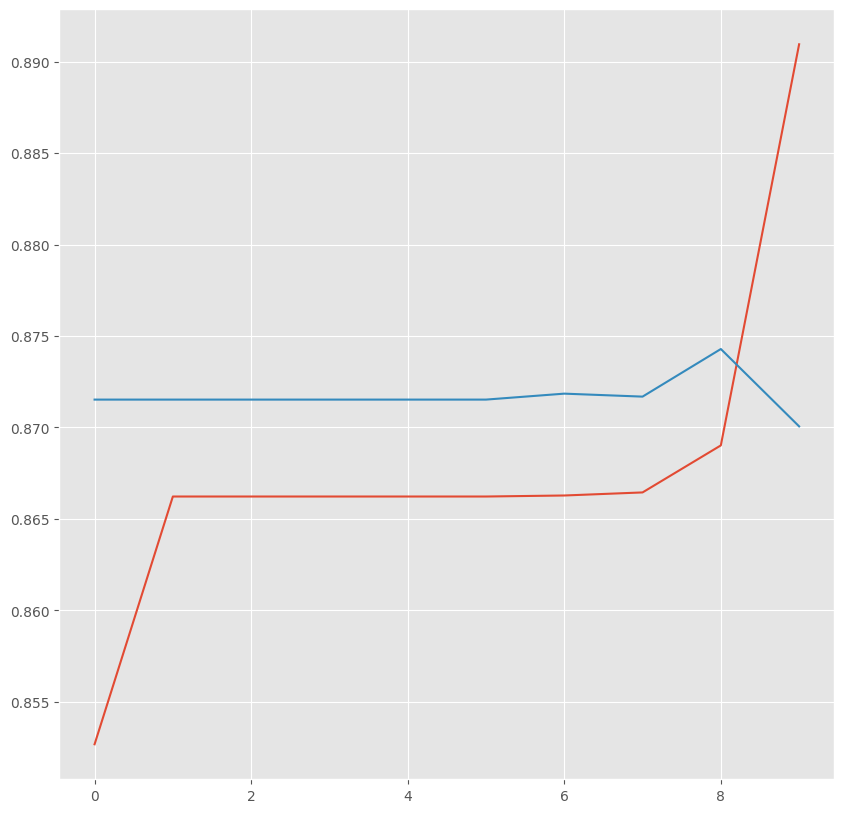

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.show()

### prediction

In [141]:
y_pred = model.predict([np.array(X_word_te),
                        np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))])

11/11 [==============================] - 1s 54ms/step


In [144]:
i = 2
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
প্রধানমন্ত্রী  : O     O
শেখ            : B-PERSON B-PERSON
হাসিনার        : L-PERSON L-PERSON
সভাপতিত্বে     : O     O
গতকাল          : O     O
সচিবালয়ে      : O     O
মন্ত্রিসভার    : O     O
নিয়মিত        : O     O
বৈঠকে          : O     O
এ              : O     O
অনুমোদন        : O     O
দেওয়া         : O     O
হয়            : O     O
।              : O     O


### function for name extraction

In [ ]:
def extract_names(sentence):
  listed_s = wrd_punc_sprtr(sentence)

  # tokenization of words
  X_word = [[word2idx[w] for w in listed_s ]]

  # word/punctuation padding
  X_word = pad_sequences(maxlen = max_len, sequences=X_word, value=word2idx['PAD'], padding='post', truncating='post')

  # characters sequencing, tokenization and padding
  X_char = []
  sent_seq = []
  for i in range(max_len):
    word_seq = []
    for j in range(max_len_char):
      try:
        word_seq.append(char2idx.get(listed_s[i][j]))
      except:
        word_seq.append(char2idx.get('PAD'))
    sent_seq.append(word_seq)
  X_char.append(np.array(sent_seq))

  # predicting
  y_pred = model.predict([np.array(X_word),
                        np.array(X_char).reshape((len(X_char), max_len, max_len_char))])

  # showing the name
  i=0
  p = np.argmax(y_pred[i], axis=-1)
  name_list = []
  for w, pred in zip(X_word[i], p):
    # if w != 0:
    if idx2tag[pred] == 'B-PERSON' or idx2tag[pred] == 'I-PERSON' or idx2tag[pred] == 'L-PERSON':
      name_list.append(idx2word[w])
  if name_list == []:
    print('দুঃখিত, কোন নাম পাওয়া যায়নি!')
  else:
    name = ' '.join(name_list)
    print(name)

In [ ]:
extract_names('ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ইন্টারন্যাশনাল বিজনেস বিভাগের অধ্যাপক খন্দকার বজলুল হক প্রথম আলো ডটকমকে জানান, বিকেল তিনটা ৫০ মিনিটে তিনি এ ধরনের অভিযোগ পেয়েছেন।')

1/1 [==============================] - 0s 37ms/step
খন্দকার বজলুল হক


### this block was used for testing

In [ ]:
for sentence in sentences:
  for wordtag in sentence:
    if wordtag[0] == 'আসলাম':
      print(sentence)

[('পুলিশ', 'O'), ('জানায়', 'O'), (',', 'O'), ('আসলাম', 'O'), ('গ্রামের', 'O'), ('বাড়ি', 'O'), ('থেকে', 'O'), ('বৃহস্পতিবার', 'U-DATE'), ('রাত', 'O'), ('আটটার', 'O'), ('দিকে', 'O'), ('মধুপুর', 'O'), ('থানার', 'O'), ('উদ্দেশে', 'O'), ('রওনা', 'O'), ('দেন', 'O'), ('।', 'O')]
[('চট্টগ্রাম', 'B-ORG'), ('জেলা', 'I-ORG'), ('ক্রীড়া', 'I-ORG'), ('সংস্থার', 'L-ORG'), ('অতিরিক্ত', 'O'), ('সাধারণ', 'O'), ('সম্পাদক', 'O'), ('ও', 'O'), ('চট্টগ্রাম', 'O'), ('মোহামেডান', 'O'), ('ক্লাবের', 'O'), ('কর্ণধার', 'O'), ('সৈয়দ', 'O'), ('শাহাবুদ্দিন', 'O'), ('শামীম', 'O'), ('প্রথম', 'O'), ('আলোকে', 'O'), ('জানান', 'O'), (',', 'O'), ('জাম্বুরি', 'O'), ('মাঠে', 'O'), ('কায়সার', 'O'), ('হামিদ', 'O'), (',', 'O'), ('শেখ', 'O'), ('আসলাম', 'O'), (',', 'O'), ('এফ', 'O'), ('আই', 'O'), ('কামালদের', 'O'), ('মতো', 'O'), ('জাতীয়', 'O'), ('ফুটবলাররা', 'O'), ('খেলেছেন', 'O'), ('।', 'O')]
[('চট্টগ্রাম', 'O'), ('জেলা', 'O'), ('ক্রীড়া', 'O'), ('সংস্থার', 'O'), ('অতিরিক্ত', 'O'), ('সাধারণ', 'O'), ('সম্পাদক', 'O'), ('ও', '

In [ ]:
sentences[0][0]

('অগ্রণী', 'B-ORG')

In [ ]:
X_char[0][1]

array([25, 22,  7, 36, 76, 26, 66, 86,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
print(sentences[0][1][0])
print(len(sentences[0][1][0]))
print(sentences[0][1][0][7])
print(char2idx.get(sentences[0][1][0][7]))

ব্যাংকের
8
র
86


In [ ]:
X_char[0][0]

array([53, 60, 22, 86, 63,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [ ]:
print(sentences[0][0][0])
print(len(sentences[0][0][0]))
print(char2idx.get(sentences[0][0][0]))

অগ্রণী
6
None


In [ ]:
char2idx

{'ী': 2,
 'ৎ': 3,
 'জ': 4,
 '—': 5,
 'ূ': 6,
 'য': 7,
 '?': 8,
 '৫': 9,
 'হ': 10,
 'খ': 11,
 'ন': 12,
 'ঢ': 13,
 'স': 14,
 'এ': 15,
 'থ': 16,
 'ঠ': 17,
 'ঔ': 18,
 '(': 19,
 'ষ': 20,
 '২': 21,
 '্': 22,
 'ঊ': 23,
 '১': 24,
 'ব': 25,
 'ক': 26,
 '\xa0': 27,
 'ধ': 28,
 'ি': 29,
 'ড': 30,
 '৭': 31,
 '৩': 32,
 'ঋ': 33,
 'চ': 34,
 ';': 35,
 'া': 36,
 'ম': 37,
 'ো': 38,
 '–': 39,
 '০': 40,
 'প': 41,
 '৪': 42,
 'য়': 43,
 'ঁ': 44,
 'ঈ': 45,
 'ফ': 46,
 'ঘ': 47,
 ')': 48,
 'ঃ': 49,
 'উ': 50,
 'ঞ': 51,
 'ভ': 52,
 'অ': 53,
 'আ': 54,
 'ই': 55,
 '.': 56,
 'শ': 57,
 '৷': 58,
 'ৈ': 59,
 'গ': 60,
 'ু': 61,
 'ও': 62,
 'ণ': 63,
 '়': 64,
 'দ': 65,
 'ে': 66,
 'ত': 67,
 '।': 68,
 'ৃ': 69,
 'ট': 70,
 'ঝ': 71,
 '৬': 72,
 '-': 73,
 'ৌ': 74,
 "'": 75,
 'ং': 76,
 '৮': 77,
 ',': 78,
 '৯': 79,
 'ঙ': 80,
 ':': 81,
 'ছ': 82,
 'ঐ': 83,
 'ল': 84,
 'ড়': 85,
 'র': 86,
 'ৗ': 87,
 'UNK': 1,
 'PAD': 0}

In [ ]:
len(chars)

86

In [ ]:
# there are nonetypes in my X_char_tr
X_char_tr

[array([[41, 36, 84, ...,  0,  0,  0],
        [15, 11, 12, ...,  0,  0,  0],
        [54, 67, 80, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]]),
 array([[53, 52, 29, ..., 86,  0,  0],
        [10, 36, 67, ...,  0,  0,  0],
        [41, 86, 29, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]]),
 array([[14, 66, 55, ...,  0,  0,  0],
        [12,  2, 67, ...,  0,  0,  0],
        [54, 84, 38, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]]),
 array([[ 4, 66,  0, ...,  0,  0,  0],
        [86, 61, 25, ...,  0,  0,  0],
        [78,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]]),
 arr

In [ ]:
np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))

array([[[41, 36, 84, ...,  0,  0,  0],
        [15, 11, 12, ...,  0,  0,  0],
        [54, 67, 80, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[53, 52, 29, ..., 86,  0,  0],
        [10, 36, 67, ...,  0,  0,  0],
        [41, 86, 29, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[14, 66, 55, ...,  0,  0,  0],
        [12,  2, 67, ...,  0,  0,  0],
        [54, 84, 38, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       ...,

       [[10, 66, 12, ...,  0,  0,  0],
        [26, 29, 14, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0

In [ ]:
np.array(X_word_tr).reshape(len(X_word_tr), max_len)

array([[10443,  4381, 10802, ...,     0,     0,     0],
       [ 7054,  1271, 11072, ...,     0,     0,     0],
       [ 5381,  6543,  5358, ...,     0,     0,     0],
       ...,
       [ 2061,  9081,     0, ...,     0,     0,     0],
       [ 6783,  6863,  1375, ...,     0,     0,     0],
       [ 8430,  7839,  7245, ...,     0,     0,     0]], dtype=int32)

In [ ]:
np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)).shape

(3042, 100, 15)

In [ ]:
type(np.array(y_tr).reshape(len(y_tr), max_len, 1))

numpy.ndarray

In [ ]:
type(emb_word)

keras.engine.keras_tensor.KerasTensor

In [ ]:
type(word_in)

keras.engine.keras_tensor.KerasTensor

In [ ]:
type(X_char_tr)

list

In [ ]:
type(X_word_tr)

numpy.ndarray

In [ ]:
type(y_tr)

numpy.ndarray

In [ ]:
print([[[w[0]] for w in s] for s in sentences[:10]])

[[['অগ্রণী'], ['ব্যাংকের'], ['জ্যেষ্ঠ'], ['কর্মকর্তা'], ['পদে'], ['নিয়োগ'], ['পরীক্ষার'], ['প্রশ্নপত্র'], ['ফাঁসের'], ['অভিযোগ'], ['উঠেছে'], ['।']], [['ব্যাংকের'], ['চেয়ারম্যানও'], ['এ'], ['অভিযোগের'], ['সত্যতা'], ['স্বীকার'], ['করেছেন'], ['।']], [['এ'], ['ছাড়া'], ['বিষয়টি'], ['তদন্ত'], ['করাও'], ['জরুরি'], ['।']], [['তাঁর'], ['দেওয়া'], ['তথ্যের'], ['ভিত্তিতে'], ['গ্রেপ্তার'], ['করা'], ['হয়েছে'], ['চেন্নাই'], ['সুপার'], ['কিংসের'], ['প্রধান'], ['গুরুনাথ'], ['মায়াপ্পনকে'], ['।']], [['কারণ'], [','], ['এর'], ['এক'], ['দিন'], ['আগে'], ['গত'], ['শুক্রবার'], ['আইন'], ['প্রতিমন্ত্রী'], ['কামরুল'], ['ইসলাম'], ['তারেকের'], ['বিরুদ্ধে'], ['এ'], ['উদ্যোগ'], ['নেওয়া'], ['হবে'], ['বলে'], ['ঘোষণা'], ['দিয়েছিলেন'], ['।']], [['অবশ্য'], ['বিদেশে'], ['থাকা'], ['আসামি'], ['ফিরিয়ে'], ['আনার'], ['ক্ষেত্রে'], ['ইন্টারপোলের'], ['ভূমিকা'], ['খুব'], ['সামান্য'], ['বলে'], ['জানিয়েছেন'], ['বাংলাদেশে'], ['এ'], ['বিষয়ে'], ['ওয়াকিবহাল'], ['ব্যক্তিরা'], ['।']], [['গতকাল'], ['ঢাকার'], ['বিশেষ'], ['জজ'], 

In [ ]:
print([[[w[1]] for w in s] for s in sentences[:10]])

[[['B-ORG'], ['L-ORG'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['B-ORG'], ['I-ORG'], ['L-ORG'], ['O'], ['B-PERSON'], ['L-PERSON'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['B-PERSON'], ['L-PERSON'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['U-GPE'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['B-PERSON'], ['L-PERSON'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O']], [['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['B-PERSON'], ['L-PERSON'], [

In [ ]:
sentences

[[('অগ্রণী', 'B-ORG'),
  ('ব্যাংকের', 'L-ORG'),
  ('জ্যেষ্ঠ', 'O'),
  ('কর্মকর্তা', 'O'),
  ('পদে', 'O'),
  ('নিয়োগ', 'O'),
  ('পরীক্ষার', 'O'),
  ('প্রশ্নপত্র', 'O'),
  ('ফাঁসের', 'O'),
  ('অভিযোগ', 'O'),
  ('উঠেছে', 'O'),
  ('।', 'O')],
 [('ব্যাংকের', 'O'),
  ('চেয়ারম্যানও', 'O'),
  ('এ', 'O'),
  ('অভিযোগের', 'O'),
  ('সত্যতা', 'O'),
  ('স্বীকার', 'O'),
  ('করেছেন', 'O'),
  ('।', 'O')],
 [('এ', 'O'),
  ('ছাড়া', 'O'),
  ('বিষয়টি', 'O'),
  ('তদন্ত', 'O'),
  ('করাও', 'O'),
  ('জরুরি', 'O'),
  ('।', 'O')],
 [('তাঁর', 'O'),
  ('দেওয়া', 'O'),
  ('তথ্যের', 'O'),
  ('ভিত্তিতে', 'O'),
  ('গ্রেপ্তার', 'O'),
  ('করা', 'O'),
  ('হয়েছে', 'O'),
  ('চেন্নাই', 'B-ORG'),
  ('সুপার', 'I-ORG'),
  ('কিংসের', 'L-ORG'),
  ('প্রধান', 'O'),
  ('গুরুনাথ', 'B-PERSON'),
  ('মায়াপ্পনকে', 'L-PERSON'),
  ('।', 'O')],
 [('কারণ', 'O'),
  (',', 'O'),
  ('এর', 'O'),
  ('এক', 'O'),
  ('দিন', 'O'),
  ('আগে', 'O'),
  ('গত', 'O'),
  ('শুক্রবার', 'O'),
  ('আইন', 'O'),
  ('প্রতিমন্ত্রী', 'O'),
  ('কামরুল', 'B-PERSON

In [ ]:
X_word

array([[ 8382,   524,  9303, ...,     0,     0,     0],
       [  524,  9293,  2025, ...,     0,     0,     0],
       [ 2025,   851, 10902, ...,     0,     0,     0],
       ...,
       [ 5876,  1035,  7244, ...,     0,     0,     0],
       [ 5876,  1035,  7244, ...,     0,     0,     0],
       [ 5876,  1035,  7244, ...,     0,     0,     0]], dtype=int32)

In [ ]:
word2idx

{'শাহপরান': 2,
 'রবিবার': 3,
 'এনইসি': 4,
 'করতেই': 5,
 'রাখার': 6,
 'খুন': 7,
 'শিউলিমালা': 8,
 '০০০': 9,
 'বরং': 10,
 'ওজোপাডিকো': 11,
 'আম্পায়ার': 12,
 'জায়গার': 13,
 'হত্যাকাণ্ড': 14,
 'নির্দেশনার': 15,
 'আহমেঞ্চদস্বাধীন': 16,
 'ওয়েবসাইট': 17,
 'আরও': 18,
 'অপরীক্ষিত': 19,
 'ছয়টায়': 20,
 'বিদ্যালয়ের': 21,
 'জুমার': 22,
 'রাস্তায়': 23,
 'কাঠামোতে': 24,
 'কদিন': 25,
 'সুযোগসুবিধা': 26,
 'প্রতিবেদনে': 27,
 'চাপ': 28,
 'লুয়ো': 29,
 'আত্মীয়': 30,
 'আকন্দনাট্যজনের': 31,
 'ওয়াশিংটন': 32,
 'কারা': 33,
 'বুলু': 34,
 'দেওয়ায়': 35,
 'দুদুর': 36,
 'পদার্থবিজ্ঞানী': 37,
 'ওয়াকিবহাল': 38,
 'আসিফ': 39,
 'সম্মিলিত': 40,
 'বিএমডব্লু': 41,
 'বর্ষ': 42,
 'জগতে': 43,
 'বলতে': 44,
 'অবস্থানরত': 45,
 'এরকম': 46,
 'কর্মজীবনে': 47,
 'বাসায়': 48,
 'ইভেন্টে': 49,
 'আসামিপক্ষ': 50,
 'রাজশাহী': 51,
 'ফজলে': 52,
 'বিরোধকে': 53,
 'ব্রিটেনের': 54,
 'দুটার': 55,
 'নায়েবে': 56,
 'কোলের': 57,
 '৮.১': 58,
 'সেট': 59,
 'উমা': 60,
 'পাশ্চাত্য': 61,
 'ক্যালকাটা': 62,
 'ঝালকাঠির': 63,
 'ঝড়': 64,
 'ইংরেজদের'

In [ ]:
tag2idx

{'I-ORG': 1,
 'I-GPE': 2,
 'L-PERSON': 3,
 'U-PERSON': 4,
 'L-LAW': 5,
 'U-GPE': 6,
 'U-DATE': 7,
 'I-PERSON': 8,
 'B-LAW': 9,
 'B-GPE': 10,
 'I-LAW': 11,
 'U-ORG': 12,
 'B-ORG': 13,
 'B-PERSON': 14,
 'L-GPE': 15,
 'L-ORG': 16,
 'O': 17,
 'PAD': 0}

In [ ]:
agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                    s["tag"].values.tolist())]
grouped = df.groupby("sentence").apply(agg_func)
sentences = [s for s in grouped]

In [ ]:
sentences[0]

[('অগ্রণী', 'B-ORG'),
 ('ব্যাংকের', 'L-ORG'),
 ('জ্যেষ্ঠ', 'O'),
 ('কর্মকর্তা', 'O'),
 ('পদে', 'O'),
 ('নিয়োগ', 'O'),
 ('পরীক্ষার', 'O'),
 ('প্রশ্নপত্র', 'O'),
 ('ফাঁসের', 'O'),
 ('অভিযোগ', 'O'),
 ('উঠেছে', 'O'),
 ('।', 'O')]

In [ ]:
n_set = 0
s = grouped["sentence {}".format(n_set)]
s

[('অগ্রণী', 'B-ORG'),
 ('ব্যাংকের', 'L-ORG'),
 ('জ্যেষ্ঠ', 'O'),
 ('কর্মকর্তা', 'O'),
 ('পদে', 'O'),
 ('নিয়োগ', 'O'),
 ('পরীক্ষার', 'O'),
 ('প্রশ্নপত্র', 'O'),
 ('ফাঁসের', 'O'),
 ('অভিযোগ', 'O'),
 ('উঠেছে', 'O'),
 ('।', 'O')]